In [ ]:
# from monai import 

In [1]:
def calculate_IoU(outputs, masks):
    predicted_masks = (outputs > 0.5).float()
    intersection = torch.sum(predicted_masks * masks)
    union = torch.sum(predicted_masks) + torch.sum(masks) - intersection
    iou = intersection / union
    return iou
    

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import random
import torch
from utils import unet, mypreprocess
from tqdm import tqdm

from segmentation_models_pytorch.losses import DiceLoss

path_dir = os.path.join(os.getcwd(), 'Human-Segmentation-Dataset-master')
image_dir = os.path.join(path_dir, 'Training_Images')
label_dir = os.path.join(path_dir, 'Ground_Truth')
map_dir_path = os.path.join(path_dir, 'train.csv')
# print(image_dir, '-----', label_dir)
transform = mypreprocess.create_transformer(img_size=320)
train_loader, valid_loader, test_loader = mypreprocess.create_data_loaders(path_dir=path_dir, image_dir=image_dir, label_dir=label_dir, data_transformer=transform)

def train_fn(data_loader, model, criterion, optimizer, device, criterion2=None, is_parallel=False, device_0=None, device_1=None):
    model.train()
    total_loss = 0
    for batch in data_loader:
        if is_parallel is False:
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)
        else:
            images, masks = batch[0].to(device_0), batch[1].to(device_1)
        
        outputs = model(images)
        
        optimizer.zero_grad()
        # print(outputs.shape) 
        # print(masks.shape)
        loss1 = criterion(outputs, masks)
        loss2 = criterion2(outputs, masks)
        loss = loss1 + loss2
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss

/home/student/sinaziaee/mini_conda/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def eval_fn(data_loader, model, criterion, device, criterion2=None, is_parallel=False, device_0=None, device_1=None):
    model.eval()
    total_loss = 0
    total_iou = 0
    with torch.no_grad():
        for batch in data_loader:
            if is_parallel is False:
                images, masks = batch
                images = images.to(device)
                masks = masks.to(device)
            else:
                images, masks = batch[0].to(device_0), batch[1].to(device_1)
            
            outputs = model(images)
            if criterion2 == None:
                loss = criterion(outputs, masks)
            else:
                loss = criterion1(outputs, masks) + criterion2(outputs, masks)
            total_loss += loss.item()
            iou = calculate_IoU(outputs, masks)
            total_iou += iou.item()
        
        avg_loss = total_loss / len(data_loader)
        avg_iou = total_iou / len(data_loader)
    return avg_loss, avg_iou   

def visualize_training(train_loss_list, valid_loss_list, valid_iou_list=None, dice_score_list=None):
    ax, fig = plt.subplots(1, 3, figsize=(12, 4))
    fig[0].plot(train_loss_list)
    fig[0].set_title("Train Loss")
    fig[1].plot(valid_loss_list)
    fig[1].set_title("Valid Loss")
    if valid_iou_list is not None:
        fig[2].plot(valid_iou_list)
        fig[2].set_title("Valid IoU")
    plt.savefig('results/train_result_fig.png')
    plt.show()

In [6]:
def train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device,
                                criterion1, criterion2 = None, device_0 = None, device_1 = None, is_parallel=True):
    if is_parallel is False:
        model = model.to(device)
    else:
        model = nn.DataParallel(model, device_ids=[0, 1])
        
    best_valid_loss = np.Inf

    train_loss_list = []
    valid_loss_list = []
    valid_iou_list = []

    for epoch in tqdm(range(n_epochs)):
        train_loss = train_fn(data_loader=train_loader, model=model, criterion=criterion1, 
                              optimizer=optimizer, device=device, criterion2=criterion2,
                              is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        valid_loss, valid_iou = eval_fn(data_loader=valid_loader, model=model, criterion=criterion1,
                                        device=device, criterion2=criterion2,
                                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        valid_iou_list.append(valid_iou)
        
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss
            directory = 'results'
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save(model.state_dict(), 'results/best_model.pt')
            print('SAVED-MODEL')
        
        if epoch % 50 == 0:
            print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')
            visualize_training(train_loss_list=train_loss_list, valid_loss_list=valid_loss_list)

  0%|          | 0/500 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 1, Train Loss: 1.3045981675386429, Valid Loss: 1.283963680267334


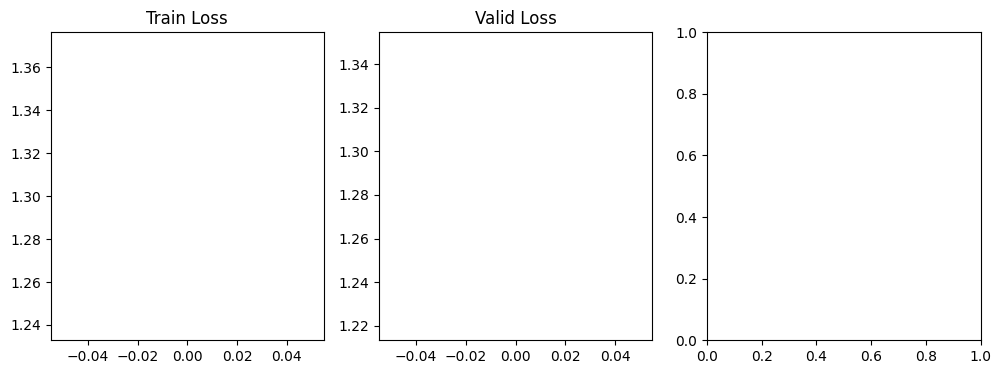

  0%|          | 1/500 [01:06<9:15:19, 66.77s/it]


KeyboardInterrupt: 

In [7]:
# Parallel training
model = unet.UNet(num_classes=1, input_channels=1)
device_0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_1 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device_0)
model.to(device_1)
model = nn.DataParallel(model, device_ids=[0, 1])
 
criterion1 = DiceLoss(mode="binary")
criterion2 = nn.BCEWithLogitsLoss()
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 500

is_parallel = True
train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, criterion2,
                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)

In [8]:
idx = 0
model.load_state_dict(torch.load('results/best_model.pt'))
data_iter = iter(valid_loader)
images, masks = next(data_iter)
image = images[idx]
mask = masks[idx]
logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

In [9]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        

In [ ]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [15]:
model = unet.UNet(input_channels=1, num_classes=1)
model.load_state_dict(torch.load('results/best_model.pt'))
model = model.to(device)

  0%|          | 0/500 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 1, Train Loss: 0.7166332229971886, Valid Loss: 0.33545786142349243


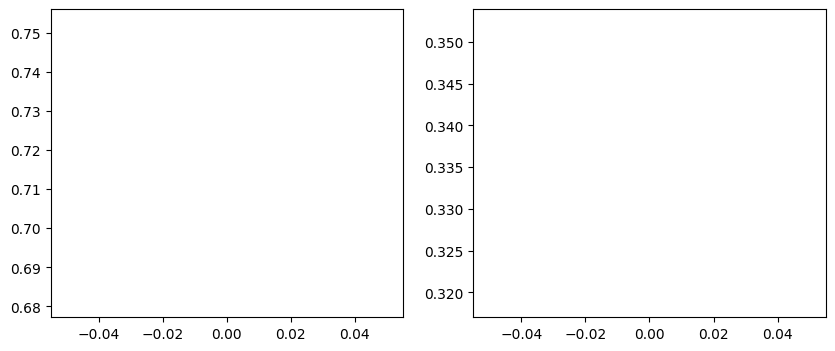

 10%|█         | 50/500 [47:29<7:08:19, 57.11s/it]

Epoch: 51, Train Loss: 0.7128799110651016, Valid Loss: 0.33545786142349243


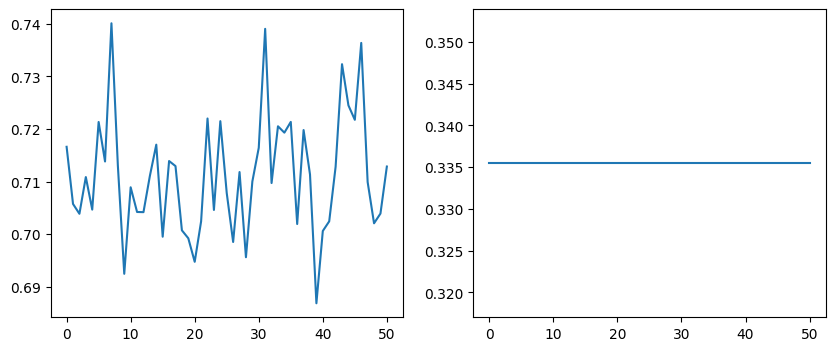

 20%|██        | 100/500 [1:34:22<6:43:47, 60.57s/it]

Epoch: 101, Train Loss: 0.7238178551197052, Valid Loss: 0.33545786142349243


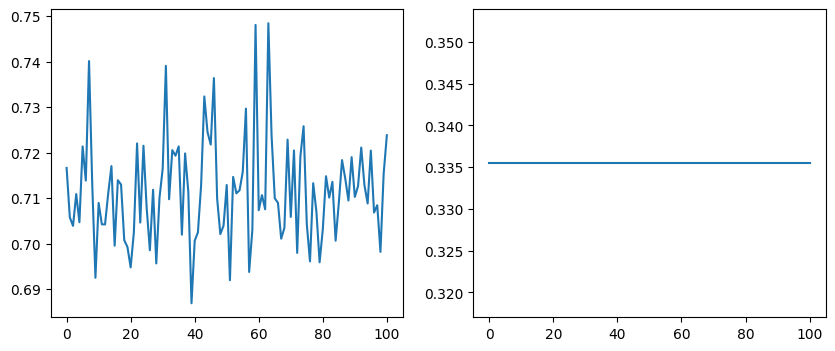

 21%|██        | 105/500 [1:40:02<6:16:20, 57.16s/it]


KeyboardInterrupt: 

In [18]:
train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, criterion2)